In [45]:
import pickle
from tensorflow.keras.models import Model
import numpy as np
import json
import os

In [84]:
# Load the model from the file
with open('CNN13.pkl', 'rb') as file_new:
    model = pickle.load(file_new)

In [85]:
genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "metal",
        3 : "pop",
        }
inv_genre_dict = {
    'blues': 0,
    'classical': 1,
    'metal': 2,
    'pop': 3
}

In [86]:
def load_data_MFCC(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return x, y

def load_data_STFT(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["stft"])
    y = np.array(data["labels"])

    return x, y

In [87]:
genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "metal",
        3 : "pop",
        }
inv_genre_dict = {
    'blues': 0,
    'classical': 1,
    'metal': 2,
    'pop': 3
}

In [88]:
penultimate_layer = model.layers[-2]

In [89]:
model_new = Model(inputs=model.input, outputs=penultimate_layer.output)

In [90]:
model_new

<Functional name=functional_1, built=True>

In [91]:
inputs_MFCC, targets_MFCC =load_data_MFCC("eeg_mfcc.json")
inputs_STFT, targets_STFT= load_data_STFT(json_path="eeg_stft.json")

In [94]:
def preprocess(json_path):
    mydict = {
            "labels": [],
            "layer": []
            }
    
    for song_idx in range(239):
        layer=[]
        for i in range(0, 16):
            mfcc = np.expand_dims(inputs_MFCC[song_idx][i], axis=-1)
            mfcc = np.expand_dims(mfcc, axis=0)

            stft = np.expand_dims(inputs_STFT[song_idx][i], axis=-1)
            stft = np.expand_dims(stft, axis=0)

            prediction = model_new.predict([mfcc, stft])
            layer.append(list(prediction.reshape(400,)))

        layer=np.array(layer).reshape(400*16,)

        mydict["labels"].append(targets_MFCC[song_idx])
        mydict["layer"].append(layer.tolist())
    
    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

def load(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["layer"])
    y = np.array(data["labels"])

    return x, y

In [96]:
if not os.path.exists("xgboost.json"):    
    preprocess("xgboost.json")
else:
    print("File already exists, skipping preprocessing.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [97]:
inputs, targets= load("xgboost.json")

In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


In [99]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(targets)

In [100]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, y_encoded, test_size=0.35, random_state=42)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# If you want to convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

/home/nai/miniconda3/envs/music/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.87


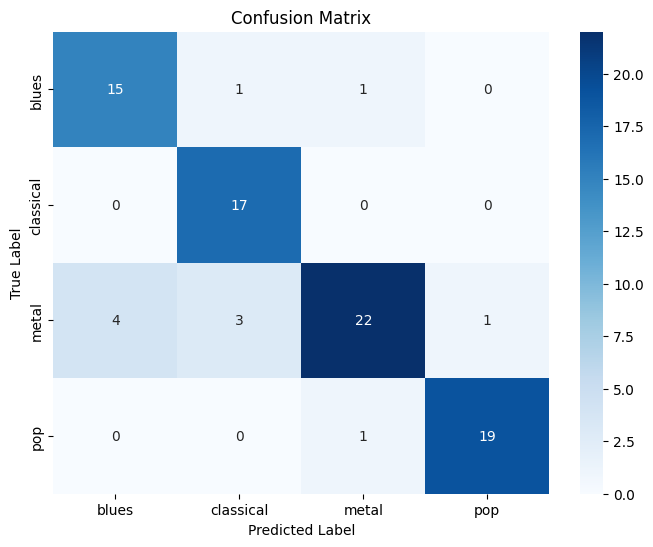

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


[0]	validation_0-mlogloss:1.10910


/home/nai/miniconda3/envs/music/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:15:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-mlogloss:0.93464
[2]	validation_0-mlogloss:0.81468
[3]	validation_0-mlogloss:0.72110
[4]	validation_0-mlogloss:0.65645
[5]	validation_0-mlogloss:0.59388
[6]	validation_0-mlogloss:0.54188
[7]	validation_0-mlogloss:0.50863
[8]	validation_0-mlogloss:0.48089
[9]	validation_0-mlogloss:0.45126
[10]	validation_0-mlogloss:0.43221
[11]	validation_0-mlogloss:0.42278
[12]	validation_0-mlogloss:0.41484
[13]	validation_0-mlogloss:0.40642
[14]	validation_0-mlogloss:0.40383
[15]	validation_0-mlogloss:0.39443
[16]	validation_0-mlogloss:0.39111
[17]	validation_0-mlogloss:0.38136
[18]	validation_0-mlogloss:0.38061
[19]	validation_0-mlogloss:0.37348
[20]	validation_0-mlogloss:0.37376
[21]	validation_0-mlogloss:0.37129
[22]	validation_0-mlogloss:0.36917
[23]	validation_0-mlogloss:0.36424
[24]	validation_0-mlogloss:0.36321
[25]	validation_0-mlogloss:0.36699
[26]	validation_0-mlogloss:0.36465
[27]	validation_0-mlogloss:0.36527
[28]	validation_0-mlogloss:0.36546
[29]	validation_0-mlogloss:0.

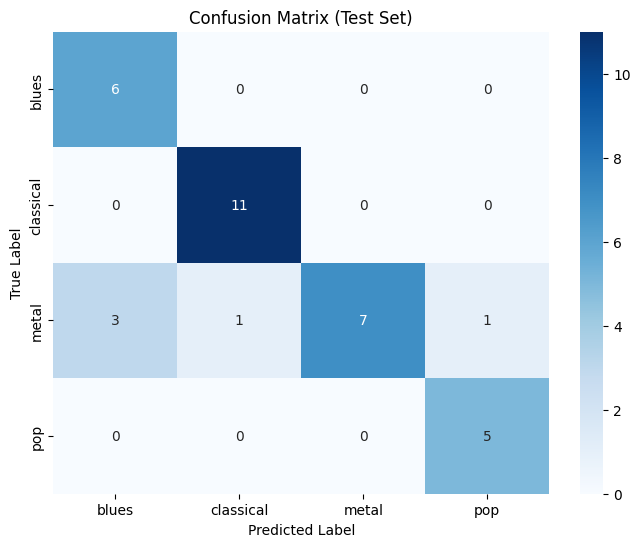

In [104]:
# Split data: 65% train, 21% validation, 14% test
X_train, X_temp, y_train, y_temp = train_test_split(inputs, y_encoded, test_size=0.35, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Train XGBoost model with evaluation set
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# You can use early stopping based on validation set performance
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()